In [1]:
from glob import glob
from datetime import datetime, date
from os.path import join, basename, expanduser
import pickle
import numpy as np
import pandas as pd
import rioxarray as rxa
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from metloom.pointdata import SnotelPointData
from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)
lidar_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar'
fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare'

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_name(fp):
    name = basename(fp)
    if '_SD_' in name:
        return datetime.strptime(name.split('_')[-2], '%Y%m%d')
    elif '-snowdepth' in name:
        return datetime.strptime(name.split('_')[0], '%Y%m%d')

def get_snow_depth_change(name, date1, date2):
    snotels = {'mores':"637:ID:SNTL", 'dry_creek':"978:ID:SNTL", 'banner':"312:ID:SNTL"}
    snotel_point = SnotelPointData(snotels[name], name + '_snotel')
    df = snotel_point.get_daily_data(
        date1, date2,
        [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    if df['SNOWDEPTH_units'].iloc[0] == 'in':
        sd = df['SNOWDEPTH']*0.0254
        return sd.iloc[-1] - sd.iloc[0]
    else:
        print('Not in inches?')

def get_snotel_loc(name):
    snotels = {'mores':"637:ID:SNTL", 'dry_creek':"978:ID:SNTL", 'banner':"312:ID:SNTL"}
    snotel_point = SnotelPointData(snotels[name], name + '_snotel')
    df = snotel_point.get_daily_data(
        '2020-01-01', '2020-01-03',
        [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    return df.geometry.iloc[0]

def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

from math import cos, sin, asin, sqrt, radians
def calc_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [ ]:
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
            print(basename(loc_dir))
            print(sd_fp)
            sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
            lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
            imgs = [im for im in low_vv_imgs if (im['flight1'] < lidar_date) & (im['flight2'] > lidar_date)]
            save = True
            if len(imgs) == 1:
                img = imgs[0]
            elif len(imgs) > 1:
                img = imgs[1]
            elif len(imgs) == 0:
                td = pd.Timedelta('1 day')
                while len(imgs) == 0:
                    imgs = [im for im in low_vv_imgs if (im['flight1'] - td < lidar_date) & (im['flight2'] + td > lidar_date)]
                    td += pd.Timedelta('1 day')
                img = imgs[0]
            phase = rxa.open_rasterio(img['fp'])
            phase = phase.rio.clip_box(*sd.rio.bounds())
            inc = rxa.open_rasterio(img['inc'])
            inc = inc.rio.reproject_match(phase)
            cor = rxa.open_rasterio(img['cor'])
            cor = cor.rio.reproject_match(phase)
            sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
            loc = get_snotel_loc(basename(loc_dir))
            snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
            phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
            snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
            if np.isnan(snotel_phase):
                snotel_phase = 0
            uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
            phase.values = uavsar_sd

            sd = sd.rio.reproject_match(phase)
            sd = sd.where(sd < 10)
            sd = sd.where(sd > 0)
            # phase = phase.where(phase < )


            gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
            fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                    ['lower left', 'right']],
                    figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
            sd = sd.where(sd < 1000)
            sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
            axes['upper left'].set_title('Lidar Snow Depth')
            phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
            axes['lower left'].set_title('Uavsar Snow Depth Change')
            for ax in ['upper left', 'lower left']:
                axes[ax].set_xlabel('')
                axes[ax].set_ylabel('')


            sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
            cond = (cors > 0.6)
            slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
            axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
            axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
            axes['right'].set_xlabel('Lidar Snow Depth')
            axes['right'].set_ylabel('Uavsar Snow Depth Change')
            name = '_'.join(basename(sd_fp).split('.')[:-1])
            fig.suptitle(f'Comparison between Lidar and Uavsar for {name}')
            if save:
                plt.savefig(join(fig_dir, basename(sd_fp)))
            plt.show()
            

In [ ]:
from rasterio.enums import Resampling

low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        # if sd_fp == '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20200218_20200219.tif':
            print(basename(loc_dir))
            print(sd_fp)
            sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
            lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
            imgs = [im for im in low_vv_imgs if (im['flight1'] < lidar_date) & (im['flight2'] > lidar_date)]
            if len(imgs) == 1:
                img = imgs[0]
            elif len(imgs) > 1:
                img = imgs[1]
                save = True
            elif len(imgs) == 0:
                td = pd.Timedelta('1 day')
                while len(imgs) == 0:
                    imgs = [im for im in low_vv_imgs if (im['flight1'] - td < lidar_date) & (im['flight2'] + td > lidar_date)]
                    td += pd.Timedelta('1 day')
                img = imgs[0]
            phase = rxa.open_rasterio(img['fp'])
            phase = phase.rio.clip_box(*sd.rio.bounds())

            desc = pd.read_csv(img['ann'])
                # calculate how to get to 30 metere resolution from 0.0005 degrees
            new_res_m = 30
            y1 = float(desc['grd.row_addr'][0])
            dy = float(desc['grd.row_mult'][0])
            x1 = float(desc['grd.col_addr'][0])
            dx = float(desc['grd.col_mult'][0])
            conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
            phase = phase.rio.reproject(phase.rio.crs, \
                                            shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                            resampling = Resampling.average)

            inc = rxa.open_rasterio(img['inc'])
            inc = inc.rio.reproject_match(phase)
            cor = rxa.open_rasterio(img['cor'])
            cor = cor.rio.reproject_match(phase)
            sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
            loc = get_snotel_loc(basename(loc_dir))
            snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
            phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
            snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
            if np.isnan(snotel_phase):
                snotel_phase = 0
            uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
            phase.values = uavsar_sd

            sd = sd.rio.reproject_match(phase)
            sd = sd.where(sd < 10)
            sd = sd.where(sd > 0)

            gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
            fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                    ['lower left', 'right']],
                    figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
            sd = sd.where(sd < 1000)
            sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
            axes['upper left'].set_title('Lidar Snow Depth')
            phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
            axes['lower left'].set_title('Uavsar Snow Depth Change')
            for ax in ['upper left', 'lower left']:
                axes[ax].set_xlabel('')
                axes[ax].set_ylabel('')


            sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
            cond = (cors > 0.6)
            slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
            axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
            axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
            axes['right'].set_xlabel('Lidar Snow Depth')
            axes['right'].set_ylabel('Uavsar Snow Depth Change')
            name = '_'.join(basename(sd_fp).split('.')[:-1])
            fig.suptitle(f'Comparison between Lidar and Uavsar for {name}')
            plt.savefig(join(fig_dir, 're30m_'+basename(sd_fp)))
            plt.show()
            

mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
mores
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.05708865076303482
Snow Depth change IQR: 0.05959625635296106


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: -0.04267557249446358. intercept: 0.08097770253505501. r_value -0.3445435766444187. p value: 5.207425348919609e-292
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.508m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.7063353657722473
Snow Depth change IQR: 0.3363393247127533


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.07472187327582154. intercept: 0.6540194149791367. r_value 0.18012564477700904. p value: 5.0221689020478324e-101
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.0011609591310843825
Snow Depth change IQR: 0.07165097817778587


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.050429526942518635. intercept: -0.025581240396578976. r_value 0.5460074344990425. p value: 0.0


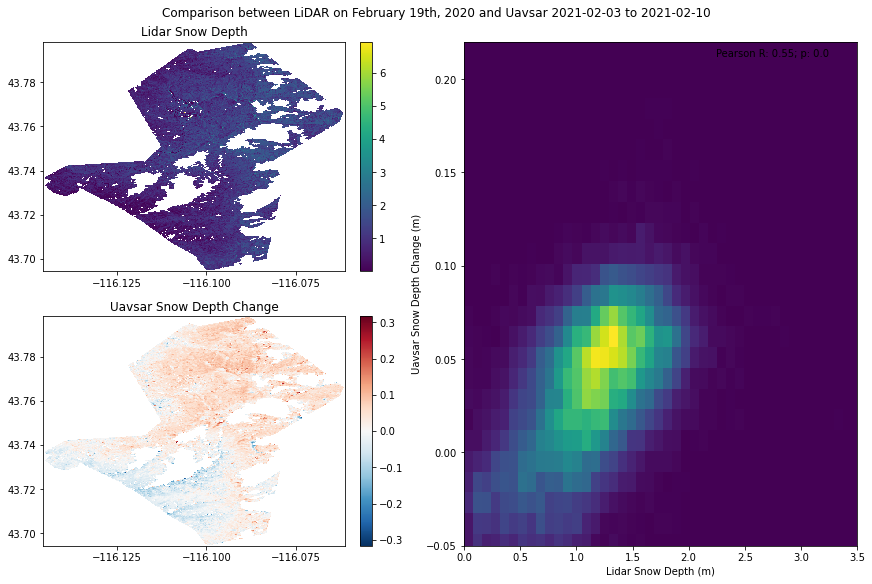

dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.030256057158112526
Snow Depth change IQR: 0.060190458338183817


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.035447471808158756. intercept: 0.011459941607089318. r_value 0.500801687596744. p value: 0.0


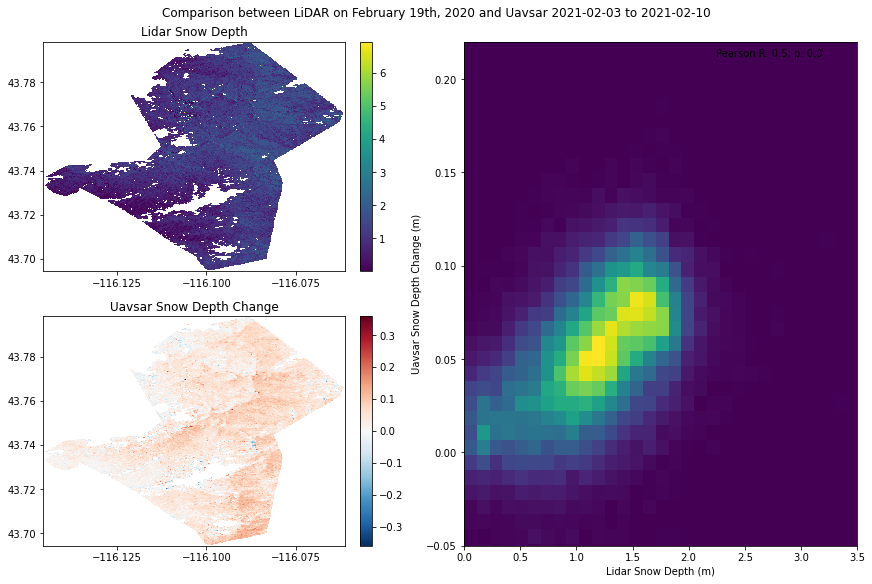

dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.14002153277397156
Snow Depth change IQR: 0.07395967654883862


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.015433719430900408. intercept: 0.1413047018273677. r_value 0.14780821620128565. p value: 1.904030122982864e-193
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.05430653318762779
Snow Depth change IQR: 0.0511920191347599


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.023419296377452367. intercept: 0.031293777209580334. r_value 0.2465170952710099. p value: 0.0
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.17202819883823395
Snow Depth change IQR: 0.07172955572605133


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.004559780060628982. intercept: 0.16489947176619277. r_value 0.045296851380135825. p value: 1.6983380463581336e-17
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: nan


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tmp/ipykernel_4396/1848106433.py:50: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
Error!
Inputs must not be empty.
Uavsar - 2021-01-27_2021-02-03
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.08902837336063385
Snow Depth change IQR: 0.0471931416541338


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.005263501256665423. intercept: 0.0885380503319682. r_value 0.07915408088235475. p value: 5.344904465522993e-72
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.06438606232404709
Snow Depth change IQR: 0.043600816279649734


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.01320229274311503. intercept: 0.051930282846275655. r_value 0.2166880908146535. p value: 0.0
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.09864376485347748
Snow Depth change IQR: 0.06684927456080914


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.0715662594637482. intercept: 0.04635715878332043. r_value 0.5427067959624352. p value: 0.0


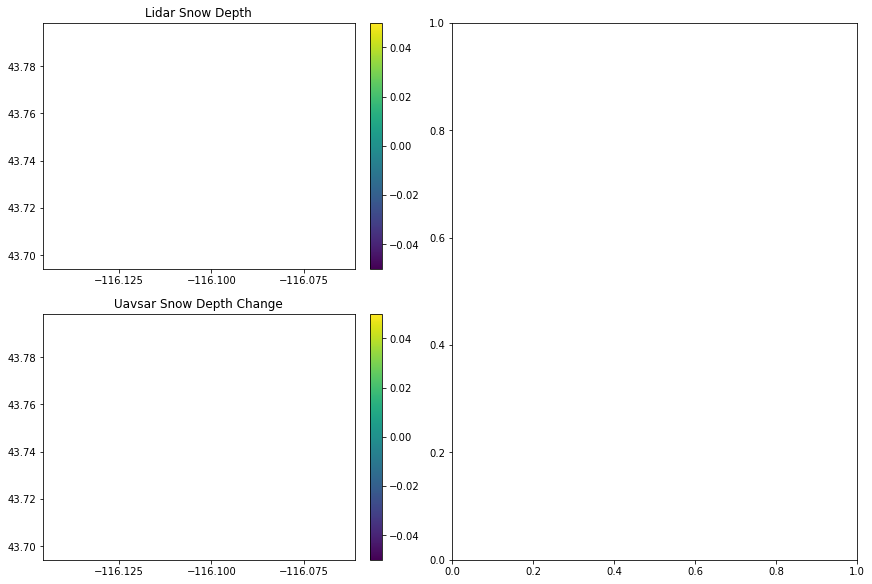

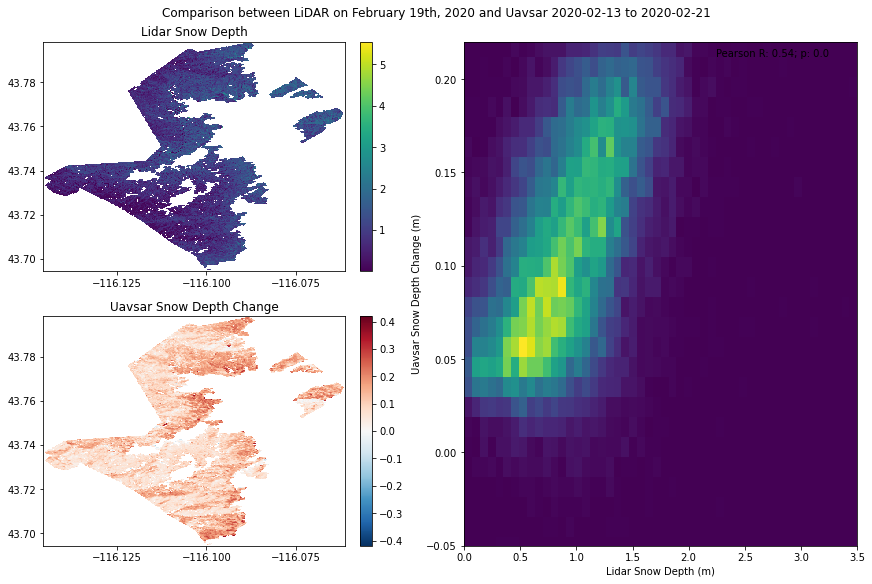

dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif
Snow depth change: 0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.0352737233042717
Snow Depth change IQR: 0.053574882447719574


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.028812996963539575. intercept: 0.017508621387651673. r_value 0.35659131491742346. p value: 0.0
dry_creek
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/dry_creek/SNEX20_QSI_SD_0.5M_USIDDC_20200219_20200219.tif


In [7]:
from rasterio.enums import Resampling

fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare/all'
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        for img in low_vv_imgs:
            try:
                print(basename(loc_dir))
                if basename(loc_dir) != 'dry_creek':
                    continue
                print(sd_fp)
                sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
                lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
                save = True
                phase = rxa.open_rasterio(img['fp'])
                phase = phase.rio.clip_box(*sd.rio.bounds())

                desc = pd.read_csv(img['ann'])
                    # calculate how to get to 30 metere resolution from 0.0005 degrees
                new_res_m = 30
                y1 = float(desc['grd.row_addr'][0])
                dy = float(desc['grd.row_mult'][0])
                x1 = float(desc['grd.col_addr'][0])
                dx = float(desc['grd.col_mult'][0])
                conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
                phase = phase.rio.reproject(phase.rio.crs, \
                                                shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                                resampling = Resampling.average)

                inc = rxa.open_rasterio(img['inc'])
                inc = inc.rio.reproject_match(phase)
                cor = rxa.open_rasterio(img['cor'])
                cor = cor.rio.reproject_match(phase)
                sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
                if sd_delta < 0:
                    sd_delta = - sd_delta
                print(f'Snow depth change: {sd_delta}m')
                loc = get_snotel_loc(basename(loc_dir))
                snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
                phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
                snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
                if np.isnan(snotel_phase):
                    snotel_phase = 0
                uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
                phase.values = uavsar_sd
                iqr = np.subtract(*np.nanpercentile(uavsar_sd, [75, 25]))

                print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
                print(f'Snow Depth change IQR: {iqr}')

                sd = sd.rio.reproject_match(phase)
                sd = sd.where(sd < 10)
                sd = sd.where(sd > 0)

                print(f'Lidar Snow depth mean {np.nanmean(sd)}')
                iqr = np.subtract(*np.nanpercentile(sd, [75, 25]))
                print(f'Lidar Snow depth IQR {iqr}')

                gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
                fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                        ['lower left', 'right']],
                        figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
                sd = sd.where(sd < 1000)
                sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
                axes['upper left'].set_title('Lidar Snow Depth')
                phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
                axes['lower left'].set_title('Uavsar Snow Depth Change')
                for ax in ['upper left', 'lower left']:
                    axes[ax].set_xlabel('')
                    axes[ax].set_ylabel('')
                    axes[ax].xaxis.set_major_locator(plt.MaxNLocator(4))

                sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
                cond = (cors > 0.5)
                slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
                axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
                axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
                axes['right'].set_xlabel('Lidar Snow Depth (m)')
                axes['right'].set_ylabel('Uavsar Snow Depth Change (m)')
                axes['right'].set_xlim(0, 3.5)
                axes['right'].set_ylim(-0.05, 0.22)
                name = '_'.join(basename(sd_fp).split('.')[:-1])
                f1 = img['flight1'].date().strftime("%Y-%m-%d")
                f2 = img['flight2'].date().strftime("%Y-%m-%d")
                fig.suptitle(f'Comparison between LiDAR on February 19th, 2020 and Uavsar {f1} to {f2}')
                if r>0.5:
                    fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare'
                    plt.savefig(join(fig_dir, basename(loc_dir)+'_re30m_'+name+'UV'+f1+'_'+f2+'.tif'))
                    fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare/all'
                    plt.savefig(join(fig_dir, basename(loc_dir)+'_re30m_'+name+'UV'+f1+'_'+f2+'.tif'))
                    plt.show()
                else:
                    fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare/all'
                    plt.savefig(join(fig_dir, basename(loc_dir)+'_re30m_'+name+'UV'+f1+'_'+f2+'.tif'))
                    plt.close()
            except ValueError as e:
                print('Error!')
                print(e)
                f1 = img['flight1'].date().strftime("%Y-%m-%d")
                f2 = img['flight2'].date().strftime("%Y-%m-%d")
                print(f'Uavsar - {f1}_{f2}')


In [ ]:
from rasterio.enums import Resampling

res = pd.DataFrame()
i = 0
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        for img in low_vv_imgs:
            try:
                sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
                lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
                save = True
                phase = rxa.open_rasterio(img['fp'])
                phase = phase.rio.clip_box(*sd.rio.bounds())

                desc = pd.read_csv(img['ann'])
                    # calculate how to get to 30 metere resolution from 0.0005 degrees
                new_res_m = 30
                y1 = float(desc['grd.row_addr'][0])
                dy = float(desc['grd.row_mult'][0])
                x1 = float(desc['grd.col_addr'][0])
                dx = float(desc['grd.col_mult'][0])
                conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
                phase = phase.rio.reproject(phase.rio.crs, \
                                                shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                                resampling = Resampling.average)

                inc = rxa.open_rasterio(img['inc'])
                inc = inc.rio.reproject_match(phase)
                cor = rxa.open_rasterio(img['cor'])
                cor = cor.rio.reproject_match(phase)
                sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
                print(f'Snow depth change: {sd_delta}m')
                loc = get_snotel_loc(basename(loc_dir))
                snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
                phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
                snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
                if np.isnan(snotel_phase):
                    snotel_phase = 0
                uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
                phase.values = uavsar_sd

                print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
                print(f'Snow Depth change IQR: {iqr}')

                sd = sd.rio.reproject_match(phase)
                sd = sd.where(sd < 10)
                sd = sd.where(sd > 0)

                print(f'Lidar Snow depth mean {np.nanmean(sd)}')
                iqr = np.subtract(*np.nanpercentile(sd, [75, 25]))
                print(f'Lidar Snow depth IQR {iqr}')

                sd = sd.where(sd < 1000)
                sd = sd.where(~np.isnan(phase))
                phase = phase.where(~np.isnan(sd))

                sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
                cond = (cors > 0.35)
                slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])

                name = '_'.join(basename(sd_fp).split('.')[:-1])
                f1 = img['flight1'].date().strftime("%Y-%m-%d")
                f2 = img['flight2'].date().strftime("%Y-%m-%d")

                res.loc[i, 'flight1'] = f1
                res.loc[i, 'flight2'] = f2
                res.loc[i, 'r'] = r
                res.loc[i, 'uavsar_sd_mean'] = np.nanmean(uavsar_sd)
                iqr = np.subtract(*np.nanpercentile(uavsar_sd, [75, 25]))
                res.loc[i, 'uavsar_sd_iqr'] = iqr
                res.loc[i, 'lidar_sd_mean'] = np.nanmean(sd)
                iqr = np.subtract(*np.nanpercentile(uavsar_sd, [75, 25]))
                res.loc[i, 'lidar_sd_iqr'] = iqr
                res.loc[i, 'snotel_sd_change'] = sd_delta
                i += 1
            except:
                pass


In [ ]:
# res = pd.read_csv('/bsuhome/zacharykeskinen/uavsar/results/sd_compare_r.csv')

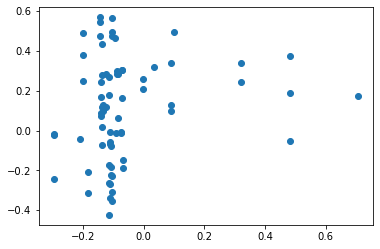

In [36]:
plt.scatter(res.uavsar_sd_mean, res.r)